## CNN Model

Another method that can be used for face recognition is CNN, a subclass of neural networks that usually use images as data. CNN's take their name from the convolution operation at their layer and differ from classical neural networks in some aspects. Convolution operation: s(t)=(x∗w)(t) (x:input, w:filter kernel and s:feature map)(https://ieeexplore.ieee.org/abstract/document/8987899). Familiar to MLP, a widely used model of CNN includes of many convolution operation followed by pooling and FC as the final layers(https://link.springer.com/article/10.1186/s40537-021-00444-8). Some advantages of CNNs are: Easy and fast training, even if the number of data grows each data does not need to be labelled as in SVM, etc.

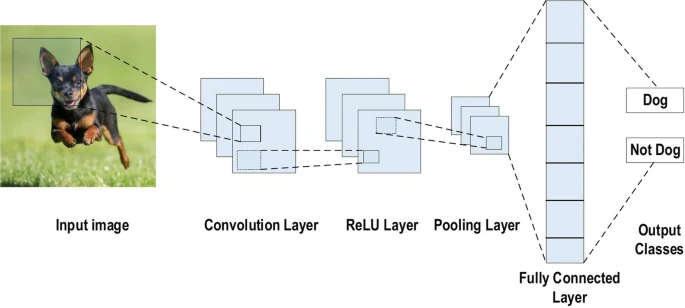

Figure A CNN Example (https://link.springer.com/article/10.1186/s40537-021-00444-8)

### Initialisation and imports

In [ ]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid, save_image
import torchvision.models
import matplotlib.pyplot
import torch.nn
from tqdm.notebook import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data Loading and Proccesing for CNN Model

In [ ]:
from_opencv_images = '/content/computervisionproject/Train'

Problems may occur in the images due to different light angles or distortions in the obtained data. This problem can be solved by calculating the mean and standard deviation of the images and normalising/standardising them to use data within a specific range(https://openaccess.thecvf.com/content/CVPR2021/html/Li_On_Feature_Normalization_and_Data_Augmentation_CVPR_2021_paper.html).
However, as it is known, the critical reason for the development and popularisation of CNN models is ImageNet. Using an ImageNet weighted model will eliminate calculating the mean and standard deviation.

In [ ]:
mean_std_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
def denorm(x, stats=mean_std_stats):
    return x * torch.Tensor(stats[1])[:,None,None] + torch.Tensor(stats[0])[:,None,None]

Batch size is a hyperparameter that must be determined to train a network. Setting the batch size too low may decrease accuracy, or setting it too high will not improve accuracy.[https://www.sciencedirect.com/science/article/pii/S2405959519303455]

Nvidia recommends a minimum batch size of `64`(They suggest setting `256` ideally) for their GPUs.[https://docs.nvidia.com/deeplearning/performance/dl-performance-convolutional/index.html]

However, the number of images used in this project is not high and the hardware used has difficulties working with high batch size values. Thus, a value that is a `multiple of 8`*italicized text* will be used in this project.

In [ ]:
opencv_img_s = 350
batch_s=16

Before the machine learning training phase, image transformation, one of the important computer vision techniques, is necessary because the model can provide additional information.[https://ieeexplore.ieee.org/abstract/document/1203211]

Common image transformations are accessible in the torchvision.transforms module. Using `Compose`, they may be chained together.[https://pytorch.org/vision/stable/transforms.html]

The following transformations are used in this project:

1.   With, `torchvision.transforms.Resize` the image is resized to the specified dimensions.
2.   With, `torchvision.transforms.GaussianBlur` the image is randomly blured.
3.   With, `torchvision.transforms.ToTensor` the `PIL Image` or `numpy.ndarray` is converted to the tensor.
4.   With, `torchvision.transforms.Normalize` the tensor image is normalize with ImageNet mean and standard deviation.

In [ ]:
image_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(opencv_img_s), torchvision.transforms.GaussianBlur(kernel_size=1, sigma=(0.1, 2.0)), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(*mean_std_stats)])

In this project, we use a dataset that we created ourselves, and the images need to be uploaded to the folders. There are some base classes for custom datasets in Pytorch. `ImageFolder` is one of these data loader classes.[https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder]

The files created for each person in the dataset are named so that later predictions can be made. With `.classes`, each person is identified by the file name.



In [ ]:
face_data = ImageFolder(from_opencv_images, transform=image_transforms)
person_names = face_data.classes

In [ ]:
print('There are', len(face_data), 'images')
print(face_data[0][0].size())
person_names

### Data Splitting for CNN Model

Pre-model preparation was made with Pytorch's significant data load utility `torch.utils.data.DataLoader` class. With constructor arguments of `DataLoader` such as `random_split`, `batch_size`, `shuffle`, `num_workers`, the data was split and prepared for the model.[https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset]

With-mask and without-mask, images were split into two more folders to %15 evaluate the model and %15 test the model. Calculated 15% of dataset with `int(len(face_data) * 15/100` then randomly split 15% of data with `random_split` in `torch.utils.data`.

In [ ]:
face_data, valid_set = random_split(face_data, [len(face_data) - (int(len(face_data) * 15/100)), (int(len(face_data) * 15/100))])
face_data, test_set = random_split(face_data, [len(face_data) - (int(len(face_data) * 15/100)), (int(len(face_data) * 15/100))])

Since `shuffle` will improve the learning phase of the model, it will be useful to `shuffle` in the data set to split for training. However, validation and test datasets are not part of the learning phase, so there is no need for the `shuffle`.

Also, Google Colab is a 2-core system. Thus, `num_workers` is fixed to 2.

In [ ]:
train_loader = DataLoader(face_data, batch_size=batch_s, shuffle=True, num_workers=2) # set num_workers to your CPU core count
val_loader = DataLoader(valid_set, batch_size=batch_s, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_s, shuffle=False, num_workers=2)

### Model Selection and Preparing for Training


In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Since there is a small data set, there is no need to work with a very high epoch value.That's why the epoch is set to 5.

In [ ]:
epochs = 20

The optimizer is a method used to update the hyperparameters (learning rate, etc.) defined in the model, which is used to reduce the losses in the training phase in a simple way(https://pytorch.org/docs/stable/optim.html). Pytorch has many optimizers to offer. In this project, Adam Optimizer is used, which requires less memory and is understandable, as an optimizer will be used only to help the learning rate.


The learning rate is responsible for the weight update of the model so that the loss in the model does not increase. As stated in Pytorch, 1e-3 was chosen as the default(https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam).


In [ ]:
optimization = torch.optim.Adam(resnet18.parameters(), lr=1e-3)

A function was created to train the model. First, the selected ResNet18 model training was set, and then the `torch.set_grad_enabled` class was set to calculate the gradient. In Training, loss and accuracy values were defined to start from 0. Images and each file name (person names) as inputs are provided to access each data with a `for` loop. Also added an optimizer to the loop to update the weights at each step. Finally, statistical recording of loss and accuracy data at each step was set.

In [ ]:
def model_training(epoch, epochs, resnet18, train_loader, loss_func, device, optimization, data_set=face_data):
    resnet18.train(True)
    torch.set_grad_enabled(True)
    model_epoch_loss, model_epochs_accuracy = 0.00, 0.00
    progress = tqdm(train_loader, total=len(train_loader))
    for img, names in progress:
        img = img.to(device)
        names = names.to(device)
        optimization.zero_grad()
        output = resnet18(img)
        _, prediction = torch.max(output, 1)
        training_loss = loss_func(output, names)
        training_loss.backward()
        optimization.step()
        model_epoch_loss += training_loss.item()
        model_epochs_accuracy += torch.sum(prediction == names).item()
        progress.set_description(f'epoch ---{epoch + 1}/{epochs}---')
        progress.set_postfix_str('training loss = {:.4f}'.format(training_loss.item()))

    model_epoch_loss = model_epoch_loss / len(train_loader)
    model_epochs_accuracy = model_epochs_accuracy / len(data_set)

    return model_epoch_loss, model_epochs_accuracy

This time, the dataset validation dataset was selected for the function created to evaluate the model. Since the target was not to train the model at this stage, the training feature of the model was disabled. Again, the loss and accuracy values were fixed to 0. A parallel loop was created with the training function to compare each stage of the training process with the evaluation set created. However, unlike the training function, an optimizer is not defined here because the weights do not need to be updated during the evaluation phase.

In [ ]:
def model_evaluation(resnet18, train_loader, loss_func, device, data_set=valid_set):
    resnet18.train(False)
    model_epoch_loss, model_epochs_accuracy = 0.00, 0.00
    progress = tqdm(train_loader, total=len(train_loader), leave=False)
    for img, names in progress:
        img = img.to(device)
        names = names.to(device)
        output = resnet18(img)
        _, prediction = torch.max(output, 1)
        evaluation_loss = loss_func(output, names)
        model_epoch_loss += evaluation_loss.item()
        model_epochs_accuracy += torch.sum(prediction == names).item()
        progress.set_description(f'model evaluation')

    model_epoch_loss = model_epoch_loss / len(train_loader)
    model_epochs_accuracy = model_epochs_accuracy / len(data_set)

    return model_epoch_loss, model_epochs_accuracy

Finally, the `fit` function was defined to run the model entirely. The `fit` function takes the number of epochs, the selected model, the loader of the training and validation set, the loss function, and the Adam optimizer parameters. Functions defined earlier are called here again and put into a loop. Losses and accuracies were calculated and recorded. Then the fit function was defined to "fit_results" for estimation.

In [ ]:
def fit(epochs, resnet18, t_loader, v_loader, loss_func, device, optimization):

    history = []
    for epoch in range(epochs):
        torch.cuda.empty_cache()
        training_loss, training_accuracy = model_training(epoch, epochs, resnet18, t_loader, loss_func, device, optimization)
        torch.cuda.empty_cache()
        validation_loss, validation_accuracy = model_evaluation(resnet18, v_loader, loss_func, device)
        history.append({'training loss': training_loss, 'training accuracy': training_accuracy, 'validation loss': validation_loss, 'validation accuracy': validation_accuracy})
        metric = "[training loss]={:.4f} - [training accuracy]={:.4f} - [validation loss]={:.4f} - [validation accuracy]={:.4f}".format(training_loss, training_accuracy, validation_loss, validation_accuracy,)
        print(metric)
    return history

### Model Training

In [ ]:
%%time
fit_results = fit(epochs, resnet18, train_loader, val_loader, torch.nn.CrossEntropyLoss(), device, optimization)

In [ ]:
def losses_graph(history):
    losses = [fit_results['training loss'] for fit_results in history]
    val_losses = [fit_results['validation loss'] for fit_results in history]
    graph,ax = matplotlib.pyplot.subplots(1,1,figsize = (10, 8))
    ax.grid('on')
    ax.plot(losses, label = 'Loss')
    ax.plot(val_losses, label = 'Validation Loss')
    ax.set_xlim(left=1, right=len(losses))
    ax.legend();
    graph.show()

In [ ]:
losses_graph(fit_results)

In [ ]:
def accuracy_graph(history):
    accuracy = [fit_results['training accuracy'] for fit_results in history]
    val_accuracy = [fit_results['validation accuracy'] for fit_results in history]
    graph,ax = matplotlib.pyplot.subplots(1,1,figsize = (10, 8))
    ax.grid('on')
    ax.plot(100 * np.array(accuracy), label = 'Accuracy')
    ax.plot(100 * np.array(val_accuracy), label = 'Validation Accuracy')
    ax.set_xlim(left=1, right=len(accuracy))
    ax.legend();
    graph.show()

In [ ]:
accuracy_graph(fit_results)

In [ ]:
y_test, y_pred = [], []
for all_img, all_names in tqdm(val_loader):
    all_img = all_img.to(device)
    all_outputs = resnet18(all_img)
    _, prediction = torch.max(all_outputs, dim = 1)
    y_test += all_names.tolist()
    y_pred += prediction.tolist()

In [ ]:
loss, acc = model_evaluation(resnet18, val_loader, torch.nn.CrossEntropyLoss(), device)
print(f'training loss: {loss} - training accuracy: {acc}')

In [ ]:
from termcolor import colored


for i, name in enumerate(person_names):
    name = name.split("_")[-1]
    person_names[i] = name

person_names

In [ ]:
idx = 16
for all_img, all_names in test_loader:
    all_img = all_img.to(device)
    all_outputs = resnet18(all_img)
    _, prediction = torch.max(all_outputs, dim = 1)
    fig, ax = matplotlib.pyplot.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denorm(all_img.cpu())
    ax.imshow(make_grid(denorm_images[:idx], nrow=8).permute(1, 2, 0).clamp(0,1))
    for pre, n in zip(prediction[:idx], all_names[:idx]):
        if n == pre.cpu():
            print(colored(person_names[pre], 'green'))
        else:
            print(colored(person_names[pre], 'red'), colored(person_names[n], 'blue'))
    break

In [ ]:
predicttestestk = '/content/predict'
predictdataset = ImageFolder(predicttestestk, transform=transformer)
predictclass = predictdataset.person_names
predict_dl = DataLoader(predictdataset, batch_size=1, shuffle=True, pin_memory=False, num_workers=3)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
cm_df = pd.DataFrame(cm)
matplotlib.pyplot.figure(figsize=(10, 10))
matplotlib.pyplot.title('Confusion Matrix')
sns.heatmap(cm_df, annot=True, cmap='Blues', square=True);

In [ ]:
print(classification_report(y_test, y_pred))